# ATLAS Basic Classifier for RPV vs. QCD

Let's put together a simple (shallow) classifier for the RPV signal.

We can try a BDT from sk-learn.

In [1]:
# System imports
from __future__ import print_function
import os

# External imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import sklearn.metrics

# Magic
%matplotlib notebook

## Prepare the data

Let's specify which data files we'll use and prepare some helper code for reading that data.

In [2]:
# Cori scratch space
input_dir = os.path.join(os.getenv('SCRATCH'), 'atlasdl', 'prod004')

# Project space (for PDSF)
#input_dir = os.path.join(os.getenv('PROJECT'), 'atlas_dl', 'numpy', 'prod004')

In [3]:
ls $input_dir

qcd_JZ10.npz  qcd_JZ3.npz  qcd_JZ6.npz  qcd_JZ9.npz
qcd_JZ11.npz  qcd_JZ4.npz  qcd_JZ7.npz  rpv_1400_850.npz
qcd_JZ12.npz  qcd_JZ5.npz  qcd_JZ8.npz


In [4]:
#samples = ['qcd_JZ3', 'qcd_JZ4', 'qcd_JZ5', 'qcd_JZ6', 'qcd_JZ7',
#           'qcd_JZ8', 'qcd_JZ9', 'qcd_JZ10', 'qcd_JZ11', 'qcd_JZ12',
#           'rpv_1400_850']
samples = ['qcd_JZ6', 'rpv_1400_850',] 
sample_files = map(lambda s: os.path.join(input_dir, s + '.npz'), samples)
sample_files

['/global/cscratch1/sd/sfarrell/atlasdl/prod004/qcd_JZ6.npz',
 '/global/cscratch1/sd/sfarrell/atlasdl/prod004/rpv_1400_850.npz']

In [5]:
def get_file_keys(file_name):
    """Retrieves the list of keys from an npz file"""
    with np.load(file_name) as f:
        keys = f.keys()
    return keys

def retrieve_data(file_name, *keys):
    """
    A helper function for retrieving some specified arrays from one npz file.
    Returns a list of arrays corresponding to the requested key name list.
    """
    with np.load(file_name) as f:
        try:
            data = [f[key] for key in keys]
        except KeyError as err:
            print('Requested key not found. Available keys:', f.keys())
            raise
    return data

### Features

Which features do we want to use as input to the classifier?
- jetxPt, jetxEta, jetxPhi, jetxM with x = [1, 2, 3, 4]
  * or should I use the leading 5 jets?
  * this might be a good enough start

Seems like my jets are already sorted by decreasing pt, so that's useful for extracting the features.

In [6]:
def parse_object_features(array, num_objects, default_val=0.):
    """
    Takes an array of object arrays and returns a fixed rank-2 array.
    Clips and pads each element as necessary.
    Output shape is (array.shape[0], num_objects).
    """
    # Create the output first
    length = array.shape[0]
    output_array = np.full((length, num_objects), default_val)
    # Fill the output
    for i in xrange(length):
        k = min(num_objects, array[i].size)
        output_array[i,:k] = array[i][:k]
    return output_array

def prepare_sample_features(sample_file, num_jets=3, max_events=None):
    print(sample_file)
    data = retrieve_data(
        sample_file, 'fatJetPt', 'fatJetEta', 'fatJetPhi', 'fatJetM')
    num_events = data[0].shape[0]
    if max_events is not None and max_events < num_events:
        data = [d[:max_events] for d in data]
    return np.hstack(parse_object_features(a, num_jets) for a in data)

In [7]:
ev_per_sample = 500000
sample_features = [prepare_sample_features(f, max_events=ev_per_sample)
                   for f in sample_files]
sample_labels = [s == 'rpv_1400_850' for s in samples]
sample_events = [sf.shape[0] for sf in sample_features]

/global/cscratch1/sd/sfarrell/atlasdl/prod004/qcd_JZ6.npz
/global/cscratch1/sd/sfarrell/atlasdl/prod004/rpv_1400_850.npz


In [8]:
X = np.concatenate(sample_features)
sy = [z*np.ones(nevt) for (z, nevt) in zip(sample_labels, sample_events)]
y = np.concatenate(sy)

In [9]:
# Retrieve the analysis SR flag
sample_passSR = [retrieve_data(f, 'passSR')[0][:ev_per_sample] for f in sample_files]
passSR = np.concatenate(sample_passSR)

In [10]:
print('X-y shapes:', X.shape, y.shape)
print('True fraction:', y.mean())

X-y shapes: (1000000, 12) (1000000,)
True fraction: 0.5


In [11]:
X_train, X_test, y_train, y_test, passSR_train, passSR_test = train_test_split(X, y, passSR)

## Train some classifiers

Some useful info here: http://scikit-learn.org/stable/modules/model_evaluation.html

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

Guille Loupe's IML tutorial material: https://github.com/glouppe/tutorials-iml2017

In [12]:
def calc_fpr_tpr(y_true, y_pred):
    """Calculate false-positive and true-positive rates"""
    tp = np.logical_and(y_true, y_pred).sum()
    fp = np.logical_and(np.logical_not(y_true), y_pred).sum()
    tpr = tp / y_true.sum()
    fpr = fp / (y_true.size - y_true.sum())
    return fpr, tpr

In [13]:
# Evaluate the existing analysis cuts
print(sklearn.metrics.classification_report(y_test, passSR_test, 
                                            target_names=['Background', 'Signal']))

# Calculate TPR and FPR for passSR
sr_fpr, sr_tpr = calc_fpr_tpr(y_test, passSR_test)
print('FPR: %f, jTPR: %f' % (sr_fpr, sr_tpr))

             precision    recall  f1-score   support

 Background       0.63      0.98      0.77    124804
     Signal       0.96      0.42      0.58    125196

avg / total       0.79      0.70      0.67    250000

FPR: 0.019270, jTPR: 0.419638


In [14]:
logreg_clf = make_pipeline(StandardScaler(), LogisticRegression())
logreg_clf.fit(X_train, y_train)
print(sklearn.metrics.classification_report(y_test, logreg_clf.predict(X_test),
                                            target_names=['QCD', 'RPV']))
print('Train set accuracy: %f' % logreg_clf.score(X_train, y_train))
print('Test set accuracy: %f' % logreg_clf.score(X_test, y_test))

             precision    recall  f1-score   support

        QCD       0.97      0.96      0.97    124804
        RPV       0.96      0.97      0.97    125196

avg / total       0.97      0.97      0.97    250000

Train set accuracy: 0.967620
Test set accuracy: 0.968736


In [15]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = make_pipeline(StandardScaler(), DecisionTreeClassifier())
dt_clf.fit(X_train, y_train)
print(sklearn.metrics.classification_report(y_test, dt_clf.predict(X_test),
                                            target_names=['QCD', 'RPV']))
print('Train set accuracy: %f' % dt_clf.score(X_train, y_train))
print('Test set accuracy: %f' % dt_clf.score(X_test, y_test))

             precision    recall  f1-score   support

        QCD       0.95      0.95      0.95    124804
        RPV       0.95      0.95      0.95    125196

avg / total       0.95      0.95      0.95    250000

Train set accuracy: 1.000000
Test set accuracy: 0.952220


In [16]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline(StandardScaler(), RandomForestClassifier())
rf_clf.fit(X_train, y_train)
print(sklearn.metrics.classification_report(y_test, rf_clf.predict(X_test),
                                            target_names=['QCD', 'RPV']))
print('Train set accuracy: %f' % rf_clf.score(X_train, y_train))
print('Test set accuracy: %f' % rf_clf.score(X_test, y_test))

             precision    recall  f1-score   support

        QCD       0.97      0.97      0.97    124804
        RPV       0.97      0.97      0.97    125196

avg / total       0.97      0.97      0.97    250000

Train set accuracy: 0.997704
Test set accuracy: 0.968068


In [17]:
from sklearn.ensemble import GradientBoostingClassifier
bdt_clf = make_pipeline(StandardScaler(), GradientBoostingClassifier())
bdt_clf.fit(X_train, y_train)
print(sklearn.metrics.classification_report(y_test, bdt_clf.predict(X_test),
                                            target_names=['QCD', 'RPV']))
print('Train set accuracy: %f' % bdt_clf.score(X_train, y_train))
print('Test set accuracy: %f' % bdt_clf.score(X_test, y_test))

             precision    recall  f1-score   support

        QCD       0.97      0.97      0.97    124804
        RPV       0.97      0.97      0.97    125196

avg / total       0.97      0.97      0.97    250000

Train set accuracy: 0.969323
Test set accuracy: 0.969800


In [18]:
from sklearn.neural_network import MLPClassifier
mlp_clf = make_pipeline(StandardScaler(), MLPClassifier())
mlp_clf.fit(X_train, y_train)
print(sklearn.metrics.classification_report(y_test, mlp_clf.predict(X_test),
                                            target_names=['QCD', 'RPV']))
print('Train set accuracy: %f' % mlp_clf.score(X_train, y_train))
print('Test set accuracy: %f' % mlp_clf.score(X_test, y_test))

             precision    recall  f1-score   support

        QCD       0.98      0.97      0.97    124804
        RPV       0.97      0.98      0.97    125196

avg / total       0.97      0.97      0.97    250000

Train set accuracy: 0.972417
Test set accuracy: 0.972884


<IPython.core.display.Javascript object>


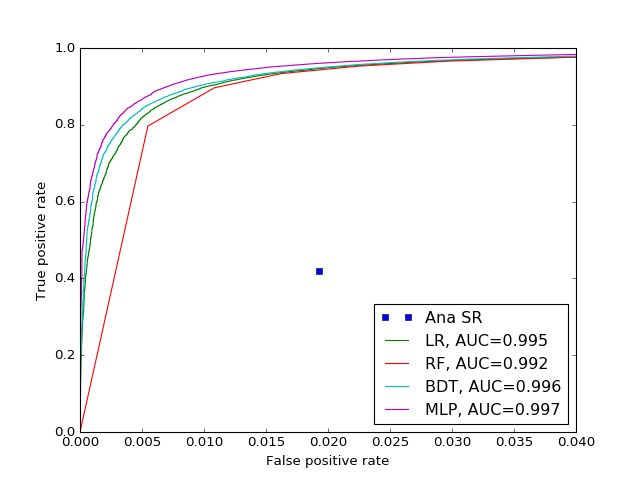

In [19]:
plt.figure()
classifiers = [logreg_clf, rf_clf, bdt_clf, mlp_clf]
clf_names = ['LR', 'RF', 'BDT', 'MLP']
# Plot the SR point
plt.plot(sr_fpr, sr_tpr, 's', label='Ana SR')
for clf, clfname in zip(classifiers, clf_names):
    probs = clf.predict_proba(X_test)[:,1]
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, probs)
    auc = sklearn.metrics.auc(fpr, tpr)
    label = clfname + ', AUC=%.3f' % auc
    plt.plot(fpr, tpr, label=label)
plt.legend(loc=0)
plt.xlim((0,0.04))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')